# Перекрестная проверка

## поиск гиперпараметров многослойного перцептрона на примере датасета MNIST

### Загрузка стандартных библиотек

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style()
%matplotlib inline
plt.rcParams['font.size'] = 14
plt.rcParams['lines.linewidth'] = 2.0
plt.rcParams['lines.markersize'] = 10.0

### Библиотеки машинного обучения: Keras и Scikit-Learn

In [2]:
from sklearn.datasets import fetch_openml, load_digits
from keras.datasets import mnist

from keras.models import Sequential, Model
from keras.layers import Activation, Dense, Dropout
from keras.utils import to_categorical
from keras.optimizers import RMSprop, SGD

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

keras_dataset = True
random_state = 42

Using TensorFlow backend.


### Описание датасета

In [3]:
digits = load_digits()
print(digits.DESCR)

.. _digits_dataset:

Optical recognition of handwritten digits dataset
--------------------------------------------------

**Data Set Characteristics:**

    :Number of Instances: 5620
    :Number of Attributes: 64
    :Attribute Information: 8x8 image of integer pixels in the range 0..16.
    :Missing Attribute Values: None
    :Creator: E. Alpaydin (alpaydin '@' boun.edu.tr)
    :Date: July; 1998

This is a copy of the test set of the UCI ML hand-written digits datasets
https://archive.ics.uci.edu/ml/datasets/Optical+Recognition+of+Handwritten+Digits

The data set contains images of hand-written digits: 10 classes where
each class refers to a digit.

Preprocessing programs made available by NIST were used to extract
normalized bitmaps of handwritten digits from a preprinted form. From a
total of 43 people, 30 contributed to the training set and different 13
to the test set. 32x32 bitmaps are divided into nonoverlapping blocks of
4x4 and the number of on pixels are counted in each blo

### Загрузка датасета

Два способа:
- с помощью sklearn
- с помощью keras (данные уже разбиты на тренировочный и тестовый наборы)

In [4]:
# Load dataset
if keras_dataset:
    (x_train, y_train), (x_test, y_test) = mnist.load_data()
else:
    digits = fetch_openml('mnist_784', version=1, cache=True)
    X, y = digits.data, digits.target
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=random_state)

y_classes = y_test.copy()

In [5]:
# Shapes for train and test
x_train.shape, x_test.shape

((60000, 28, 28), (10000, 28, 28))

### Изображение - карта признаков

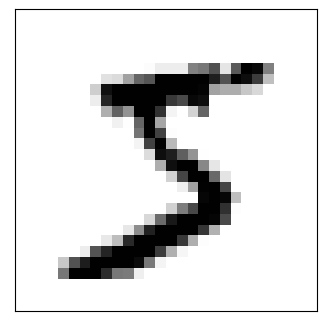

In [6]:
# Plot single digit
plt.figure('Some digit', figsize=(4, 4), dpi=100)
plt.imshow(x_train[0].reshape(28, 28), cmap='binary')
plt.xticks([], [])
plt.yticks([], [])
plt.grid(False)

### Набор рукописных цифр

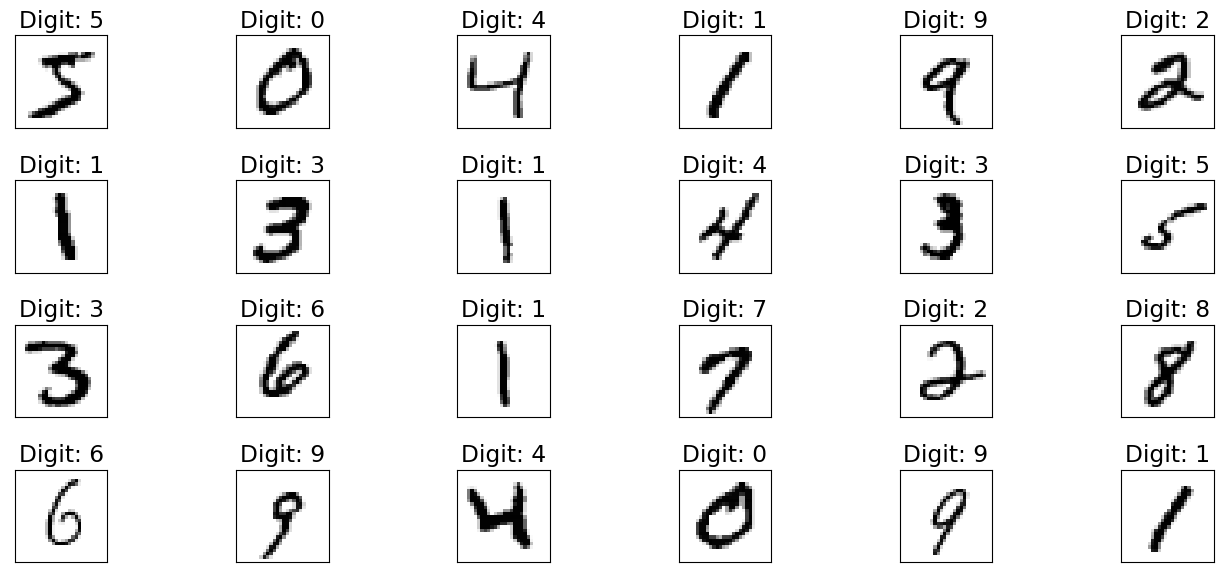

In [7]:
if 1:
    # Plot some digits
    plt.figure('MNIST Dataset', figsize=(14, 6), dpi=100)
    for i in range(24):
        plt.subplot(4, 6, i+1)
        plt.imshow(x_train[i].reshape(28, 28), cmap='binary')
        plt.title('Digit: {}'.format(y_train[i]))
        plt.grid(False)
        plt.xticks([], [])
        plt.yticks([], [])
    plt.tight_layout()

### Подготовка данных

- Преобразование размерностей,
- Масштабирование признаков (нормализация в диапазон [0, 1]),
- Преборазование категориальных меток.

In [8]:
# Prepare data for your model
if keras_dataset:
    N, M = x_train.shape[1], x_train.shape[2]

    x_train = x_train.reshape((60000, N * M))
    x_test = x_test.reshape((10000, N * M))


x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test  samples')

# One-hot label encoding
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

60000 train samples
10000 test  samples


### Использование моделей Keras в Scikit-learn

Для этого необходимо определить функцию-обертку `KerasClassifier` или `KerasRegressor` в зависимости от задачи.

```python
def create_model():
	# ...
	return model
 
model = KerasClassifier(build_fn=create_model, epochs=50)
```

Конструктор для `KerasClassifier` может принимать аргументы, используемые в процессе обучения (количество эпох, размер мини-батча и т.д.)

Кроме того, конструктор может принимать аргументы в самой модели для задания независимых классификаторов:


```python
def create_model(dropout_rate=0.5):
	# ...
	return model
 
model = KerasClassifier(build_fn=create_model, dropout_rate=0.2)
```
___

### GridSearchCV

В `sklearn` с помощью перекрестной проверки можно производить поиск гиперпараметров модели. Для этого создается словарь, в который помещаются гиперпараметры и значения, на которых требуется проверить модель. По умолчанию GridSearchCV использует один процессор, но можно установить произвольное значение (в зависимости от используемых ресурсов). Значение `-1` предполагает использование всех ядер системы. 

GridSearchCV перебирает все возможные варианты и строит модели для каждой комбинации. Процесс обучения использует всю выборку данных, а в качестве разбиения используется кросс-валидация по k-fold. Параметр `cv = 5` устанавливает разбиение датасета на 5 частей.

```python
param_grid = dict(
    epochs = [10, 20, 30],
    batch_size = [32, 64, 128]
)

grid_search = GridSearchCV(
    estimator=model, 
    param_grid=param_grid, 
    n_jobs=-1, 
    cv=5
)

grid_result = grid_search.fit(X, y)
```

`X` - матрица объекты-признаки, `y` - метки (ответы) выборки.

Лучший результат можно найти с помощью методов:
- `best_score_` - выдает наилучшие результаты после завершения поиска,
- `best_params_` - выдает лучшие значения гипер-параметров.


## Поиск гиперпараметров

### GridSearch: Batch size & epochs

Посмотрим, как с помощью `sklearn` и `keras` найти лучшие параметры модели:
- `batch_size` - количество выборок (пакетов), проходящих через сеть в процессе обучения (forward propagation)
- `number_of_epochs` - количество проходов датасета через нейронную сеть в прямом и обратном направлении.


In [9]:
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier

In [10]:
digits = fetch_openml('mnist_784', version=1, cache=True)
X, y = digits.data, digits.target

# Normalize dataset and apply ohe on labels
X = X.astype('float32') / 255
y = to_categorical(y)

X.shape, y.shape

((70000, 784), (70000, 10))

### Многослойный перцептрон

Для обучения возьмем модель многослойного перцептрона. Зададим несколько полносвязных слоев, а также слои функции активации.

- Полносвязный слой
- Функция активации ReLU
- Полносвязный слой (число нейронов = число классов)
- Фунция активации Softmax


### Функция потерь и метрики

- Функция потерь: категориальная кросс-энтропия,
- Метрика: точность (аккуратность),
- Алгоритм - RMS Propagation.

```python
model.compile(
    optimizer=RMSprop(),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
```

### GridSearch
Перекрестную проверку будем делать по количеству эпох и размеру батча:
```python
# Tuning parameters
batch_sizes = [16, 32, 64, 128]
epochs = [5, 10]
```

In [11]:
def create_model():
    # NN model
    model = Sequential()
    model.add(Dense(512, input_shape=(X.shape[1], )))
    model.add(Activation('relu'))
    model.add(Dense(y.shape[1]))
    model.add(Activation('softmax'))
    # Set loss, metrics, optimizer
    model.compile(loss='categorical_crossentropy', 
                  optimizer=RMSprop(), 
                  metrics=['accuracy'])
    return model

# Create model
keras_clf = KerasClassifier(build_fn=create_model, verbose=0)

# Tuning parameters
batch_sizes = [32, 64, 128]
epochs = [5, 10]

# GridSearch parameters
param_grid = dict(batch_size=batch_sizes, epochs=epochs)

grid_search = GridSearchCV(
    estimator=keras_clf, 
    param_grid=param_grid, 
    verbose=1,
    n_jobs=4, 
    cv=3
)

In [12]:
%%time
grid_result = grid_search.fit(X, y)

Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  18 out of  18 | elapsed:  4.7min finished


CPU times: user 2min, sys: 5.8 s, total: 2min 6s
Wall time: 5min 18s


### Результаты перекрестной проверки

In [13]:
print(f'Best score: {grid_result.best_score_ :0.4f} using {grid_result.best_params_}\n')

means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']

for m, s, p in zip(means, stds, params):
    print(f'Mean: {m :0.3f} Std: {s :0.6f} with: {p}')

Best score: 0.9793 using {'batch_size': 128, 'epochs': 10}

Mean: 0.974 Std: 0.000875 with: {'batch_size': 32, 'epochs': 5}
Mean: 0.978 Std: 0.001356 with: {'batch_size': 32, 'epochs': 10}
Mean: 0.972 Std: 0.002519 with: {'batch_size': 64, 'epochs': 5}
Mean: 0.978 Std: 0.000986 with: {'batch_size': 64, 'epochs': 10}
Mean: 0.974 Std: 0.000730 with: {'batch_size': 128, 'epochs': 5}
Mean: 0.979 Std: 0.000961 with: {'batch_size': 128, 'epochs': 10}


## Поиск гиперпараметров

### GridSearch: optimization algorithm

Посмотрим, как с помощью `sklearn` и `keras` найти лучшие параметры модели `optimizer`.

```python
optimizer = ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam']
```

In [14]:
def create_model(optimizer='SGD'):
    # NN model
    model = Sequential()
    model.add(Dense(512, input_shape=(X.shape[1], )))
    model.add(Activation('relu'))
    model.add(Dense(y.shape[1]))
    model.add(Activation('softmax'))
    # Set loss, metrics, optimizer
    model.compile(loss='categorical_crossentropy', 
                  optimizer=optimizer, 
                  metrics=['accuracy'])
    return model

# Create model
keras_clf = KerasClassifier(
    build_fn=create_model, 
    epochs=5, 
    batch_size=128, 
    verbose=0
)

# Tuning parameters
optimizer = ['SGD', 'RMSprop', 'Adagrad', 'Adam']

# GridSearch parameters
param_grid = dict(optimizer=optimizer)

grid_search = GridSearchCV(
    estimator=keras_clf, 
    param_grid=param_grid, 
    verbose=2,
    n_jobs=4, 
    cv=3
)

In [15]:
%%time
grid_result = grid_search.fit(X, y)

Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  12 out of  12 | elapsed:  1.2min remaining:    0.0s
[Parallel(n_jobs=4)]: Done  12 out of  12 | elapsed:  1.2min finished


CPU times: user 1min, sys: 2.63 s, total: 1min 3s
Wall time: 1min 30s


### Результаты перекрестной проверки

In [16]:
print(f'Best score: {grid_result.best_score_ :0.4f} using {grid_result.best_params_}\n')

means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']

for m, s, p in zip(means, stds, params):
    print(f'Mean: {m :0.3f} Std: {s :0.6f} with: {p}')

Best score: 0.9755 using {'optimizer': 'RMSprop'}

Mean: 0.901 Std: 0.006000 with: {'optimizer': 'SGD'}
Mean: 0.975 Std: 0.001291 with: {'optimizer': 'RMSprop'}
Mean: 0.970 Std: 0.001192 with: {'optimizer': 'Adagrad'}
Mean: 0.974 Std: 0.000530 with: {'optimizer': 'Adam'}


## Поиск гиперпараметров

### GridSearch: learning rate

Посмотрим, как с помощью `sklearn` и `keras` найти лучшие параметры скорости обучения модели `learning_rate`. Она определяет на сколько обновляются веса в конце каждого прохода.

In [17]:
def create_model(learn_rate=0.01):
    # NN model
    model = Sequential()
    model.add(Dense(512, input_shape=(X.shape[1], )))
    model.add(Activation('relu'))
    model.add(Dense(y.shape[1]))
    model.add(Activation('softmax'))
    # Set loss, metrics, optimizer
    model.compile(loss='categorical_crossentropy', 
                  optimizer=SGD(lr=learn_rate), 
                  metrics=['accuracy'])
    return model

# Create model
keras_clf = KerasClassifier(
    build_fn=create_model, 
    epochs=5, 
    batch_size=128, 
    verbose=0
)

# Tuning parameters
learn_rate = [0.01, 0.1, 0.2, 0.5]

# GridSearch parameters
param_grid = dict(learn_rate=learn_rate)

grid_search = GridSearchCV(
    estimator=keras_clf, 
    param_grid=param_grid, 
    verbose=2,
    n_jobs=4, 
    cv=3
)

In [18]:
%%time
grid_result = grid_search.fit(X, y)

Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  12 out of  12 | elapsed:   57.2s remaining:    0.0s
[Parallel(n_jobs=4)]: Done  12 out of  12 | elapsed:   57.2s finished


CPU times: user 51.7 s, sys: 1.98 s, total: 53.7 s
Wall time: 1min 14s


### Результаты перекрестной проверки

In [19]:
print(f'Best score: {grid_result.best_score_ :0.4f} using {grid_result.best_params_}\n')

means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']

for m, s, p in zip(means, stds, params):
    print(f'Mean: {m :0.3f} Std: {s :0.6f} with: {p}')

Best score: 0.9743 using {'learn_rate': 0.5}

Mean: 0.900 Std: 0.004975 with: {'learn_rate': 0.01}
Mean: 0.952 Std: 0.002908 with: {'learn_rate': 0.1}
Mean: 0.965 Std: 0.001163 with: {'learn_rate': 0.2}
Mean: 0.974 Std: 0.001249 with: {'learn_rate': 0.5}


## Поиск гиперпараметров

### GridSearch: Weight Initialization

Посмотрим, как с помощью `sklearn` и `keras` найти лучшие параметры инициализации весов модели `weight_initialization`. 

```python
# Tuning parameters
init_mode = [
    'uniform', 
    'lecun_uniform', 
    'normal', 
    'zero', 
    'glorot_normal', 
    'glorot_uniform', 
    'he_normal', 
    'he_uniform'
]
```

In [20]:
def create_model(init_mode='uniform'):
    # NN model
    model = Sequential()
    model.add(Dense(512, kernel_initializer=init_mode, input_shape=(X.shape[1], )))
    model.add(Activation('relu'))
    model.add(Dense(y.shape[1], kernel_initializer=init_mode))
    model.add(Activation('softmax'))
    # Set loss, metrics, optimizer
    model.compile(loss='categorical_crossentropy', 
                  optimizer=RMSprop(), 
                  metrics=['accuracy'])
    return model

# Create model
keras_clf = KerasClassifier(
    build_fn=create_model, 
    epochs=5, 
    batch_size=64, 
    verbose=0
)

# Tuning parameters
init_mode = [
    'uniform',  
    'normal', 
    'zero',
    'glorot_uniform', 
    'he_normal', 
]

# GridSearch parameters
param_grid = dict(init_mode=init_mode)

grid_search = GridSearchCV(
    estimator=keras_clf, 
    param_grid=param_grid, 
    verbose=2,
    n_jobs=4, 
    cv=3
)

In [21]:
%%time
grid_result = grid_search.fit(X, y)

Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  15 out of  15 | elapsed:  2.4min finished


CPU times: user 1min 29s, sys: 4.97 s, total: 1min 34s
Wall time: 2min 49s


### Результаты перекрестной проверки

In [22]:
print(f'Best score: {grid_result.best_score_ :0.4f} using {grid_result.best_params_}\n')

means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']

for m, s, p in zip(means, stds, params):
    print(f'Mean: {m :0.3f} Std: {s :0.6f} with: {p}')

Best score: 0.9766 using {'init_mode': 'normal'}

Mean: 0.976 Std: 0.000173 with: {'init_mode': 'uniform'}
Mean: 0.977 Std: 0.001350 with: {'init_mode': 'normal'}
Mean: 0.113 Std: 0.001898 with: {'init_mode': 'zero'}
Mean: 0.975 Std: 0.001451 with: {'init_mode': 'glorot_uniform'}
Mean: 0.976 Std: 0.001068 with: {'init_mode': 'he_normal'}


## Поиск гиперпараметров

### GridSearch: функция активации

Посмотрим, как с помощью `sklearn` и `keras` найти лучшие параметры функции активации `activation`. 

```python
# Tuning parameters
activations = [
    'softmax', 
    'softplus', 
    'softsign', 
    'relu', 
    'tanh', 
    'sigmoid', 
    'hard_sigmoid', 
    'linear'
]
```

In [23]:
def create_model(activation='relu'):
    # NN model
    model = Sequential()
    model.add(Dense(512, activation=activation, input_shape=(X.shape[1], )))
    model.add(Dense(y.shape[1]))
    model.add(Activation('softmax'))
    # Set loss, metrics, optimizer
    model.compile(loss='categorical_crossentropy', 
                  optimizer=RMSprop(), 
                  metrics=['accuracy'])
    return model

# Create model
keras_clf = KerasClassifier(
    build_fn=create_model, 
    epochs=5, 
    batch_size=64, 
    verbose=0
)

# Tuning parameters
activation = [ 
    'relu', 
    'tanh', 
    'sigmoid',
    'linear'
]

# GridSearch parameters
param_grid = dict(activation=activation)

grid_search = GridSearchCV(
    estimator=keras_clf, 
    param_grid=param_grid, 
    verbose=2,
    n_jobs=4, 
    cv=3
)

In [24]:
%%time
grid_result = grid_search.fit(X, y)

Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  12 out of  12 | elapsed:  1.9min remaining:    0.0s
[Parallel(n_jobs=4)]: Done  12 out of  12 | elapsed:  1.9min finished


CPU times: user 1min 30s, sys: 4.82 s, total: 1min 35s
Wall time: 2min 21s


### Результаты перекрестной проверки

In [25]:
print(f'Best score: {grid_result.best_score_ :0.4f} using {grid_result.best_params_}\n')

means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']

for m, s, p in zip(means, stds, params):
    print(f'Mean: {m :0.3f} Std: {s :0.6f} with: {p}')

Best score: 0.9757 using {'activation': 'relu'}

Mean: 0.976 Std: 0.000668 with: {'activation': 'relu'}
Mean: 0.969 Std: 0.001645 with: {'activation': 'tanh'}
Mean: 0.961 Std: 0.000872 with: {'activation': 'sigmoid'}
Mean: 0.895 Std: 0.012805 with: {'activation': 'linear'}


## Поиск гиперпараметров

### GridSearch: регуляризация Dropout

Посмотрим, как с помощью `sklearn` и `keras` найти лучшие параметры регуляризации с помощью `Dropout`. 

In [26]:
def create_model(dropout_rate=0.0):
    # NN model
    model = Sequential()
    model.add(Dense(512, activation='relu', input_shape=(X.shape[1], )))
    model.add(Dropout(dropout_rate))
    model.add(Dense(y.shape[1]))
    model.add(Activation('softmax'))
    
    # Set loss, metrics, optimizer
    model.compile(loss='categorical_crossentropy', 
                  optimizer=RMSprop(), 
                  metrics=['accuracy'])
    return model

# Create model
keras_clf = KerasClassifier(
    build_fn=create_model, 
    epochs=5, 
    batch_size=64, 
    verbose=0
)

# Tuning parameters
dropout_rate = [0.0, 0.2, 0.4, 0.6, 0.8]

# GridSearch parameters
param_grid = dict(dropout_rate=dropout_rate)

grid_search = GridSearchCV(
    estimator=keras_clf, 
    param_grid=param_grid, 
    verbose=2,
    n_jobs=4, 
    cv=3
)

In [27]:
%%time
grid_result = grid_search.fit(X, y)

Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  15 out of  15 | elapsed:  2.5min finished


CPU times: user 1min 37s, sys: 4.68 s, total: 1min 42s
Wall time: 3min


### Результаты перекрестной проверки

In [28]:
print(f'Best score: {grid_result.best_score_ :0.4f} using {grid_result.best_params_}\n')

means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']

for m, s, p in zip(means, stds, params):
    print(f'Mean: {m :0.3f} Std: {s :0.6f} with: {p}')

Best score: 0.9759 using {'dropout_rate': 0.2}

Mean: 0.976 Std: 0.000937 with: {'dropout_rate': 0.0}
Mean: 0.976 Std: 0.000622 with: {'dropout_rate': 0.2}
Mean: 0.974 Std: 0.001092 with: {'dropout_rate': 0.4}
Mean: 0.971 Std: 0.001779 with: {'dropout_rate': 0.6}
Mean: 0.962 Std: 0.002625 with: {'dropout_rate': 0.8}


## Поиск гиперпараметров

### GridSearch: количество нейронов скрытого слоя

Посмотрим, как с помощью `sklearn` и `keras` найти лучшие параметры количества нейронов в первом скрытом слое. Второй слой остается без изменений, т.к. решается задача классификации по 10 классам (число рукописных цифр).

In [29]:
def create_model(neurons=100):
    # NN model
    model = Sequential()
    model.add(Dense(neurons, activation='relu', input_shape=(X.shape[1], )))
    model.add(Dense(y.shape[1], activation='softmax'))
    
    # Set loss, metrics, optimizer
    model.compile(loss='categorical_crossentropy', 
                  optimizer=RMSprop(), 
                  metrics=['accuracy'])
    return model

# Create model
keras_clf = KerasClassifier(
    build_fn=create_model, 
    epochs=5, 
    batch_size=64, 
    verbose=0
)

# Tuning parameters
neurons = [50, 100, 200, 500]

# GridSearch parameters
param_grid = dict(neurons=neurons)

grid_search = GridSearchCV(
    estimator=keras_clf, 
    param_grid=param_grid, 
    verbose=2,
    n_jobs=4, 
    cv=3
)

In [30]:
%%time
grid_result = grid_search.fit(X, y)

Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  12 out of  12 | elapsed:  1.0min remaining:    0.0s
[Parallel(n_jobs=4)]: Done  12 out of  12 | elapsed:  1.0min finished


CPU times: user 1min 24s, sys: 4.95 s, total: 1min 29s
Wall time: 1min 27s


### Результаты перекрестной проверки

In [31]:
print(f'Best score: {grid_result.best_score_ :0.4f} using {grid_result.best_params_}\n')

means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']

for m, s, p in zip(means, stds, params):
    print(f'Mean: {m :0.3f} Std: {s :0.6f} with: {p}')

Best score: 0.9750 using {'neurons': 500}

Mean: 0.960 Std: 0.002646 with: {'neurons': 50}
Mean: 0.968 Std: 0.002265 with: {'neurons': 100}
Mean: 0.970 Std: 0.001601 with: {'neurons': 200}
Mean: 0.975 Std: 0.000387 with: {'neurons': 500}


### Советы по оптимизации гиперпараметров

- Перекрестная проверка k-fold: в зависимости от размера датасета и сложности модели можно варьировать параметр `k`. Типичные значения для кросс-валидации `cv = 3, 5, 10`.
- Проверка всех результатов: бывают случаи, когда в ходе перекрестной проверки получилось лучшее решение с заведомо плохими параметрами. Внимательно смотрите на значения математического ожидания и разброса, а также времени обучения модели. Иногда лучше выбрать модель, обучающуюся в 10 раз быстрее, но дающую результаты чуть хуже.
- При наличии свободных ресурсов обязательно распараллеливайте процессы. 
- В связи с тем, что глубокие нейронные сети обучаются крайне долго, попробуйте обучать их на датасетах меньшего размера. Это поможет прикинуть вектор развития модели и дальнейшей её оптимизации.
- С осторожностью используйте результаты модели для других задач. Скорее всего, правильнее будет обучить сеть заново, чем пользоваться результатами предыдущих изысканий.
- Делайте ваши проекты воспроизводимыми. Для этого фиксируйте значения `seed` и `random_state` ваших моделей и генераторов случайных чисел.

### График функции потерь и точности на каждой эпохе

In [32]:
# NN model
model = Sequential()
model.add(Dense(784, activation='relu', input_shape=(X.shape[1], )))
model.add(Dropout(0.2))
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(y.shape[1]))
model.add(Activation('softmax'))

# Set loss, metrics, optimizer
model.compile(loss='categorical_crossentropy', 
              optimizer=RMSprop(), 
              metrics=['accuracy'])

hmodel = model.fit(x_train, y_train,
                   batch_size=128,
                   epochs=20,
                   verbose=1,
                   workers=4,
                   validation_data=(x_test, y_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 3s 57us/step - loss: 0.2728 - accuracy: 0.9176 - val_loss: 0.1066 - val_accuracy: 0.9656
Epoch 2/20
60000/60000 [==============================] - 3s 56us/step - loss: 0.1108 - accuracy: 0.9669 - val_loss: 0.0863 - val_accuracy: 0.9746
Epoch 3/20
60000/60000 [==============================] - 3s 56us/step - loss: 0.0804 - accuracy: 0.9761 - val_loss: 0.0936 - val_accuracy: 0.9730
Epoch 4/20
60000/60000 [==============================] - 3s 56us/step - loss: 0.0645 - accuracy: 0.9808 - val_loss: 0.0717 - val_accuracy: 0.9798
Epoch 5/20
60000/60000 [==============================] - 3s 56us/step - loss: 0.0525 - accuracy: 0.9846 - val_loss: 0.0682 - val_accuracy: 0.9824
Epoch 6/20
60000/60000 [==============================] - 3s 56us/step - loss: 0.0440 - accuracy: 0.9866 - val_loss: 0.0678 - val_accuracy: 0.9825
Epoch 7/20
60000/60000 [==============================] - 3s 56us/st

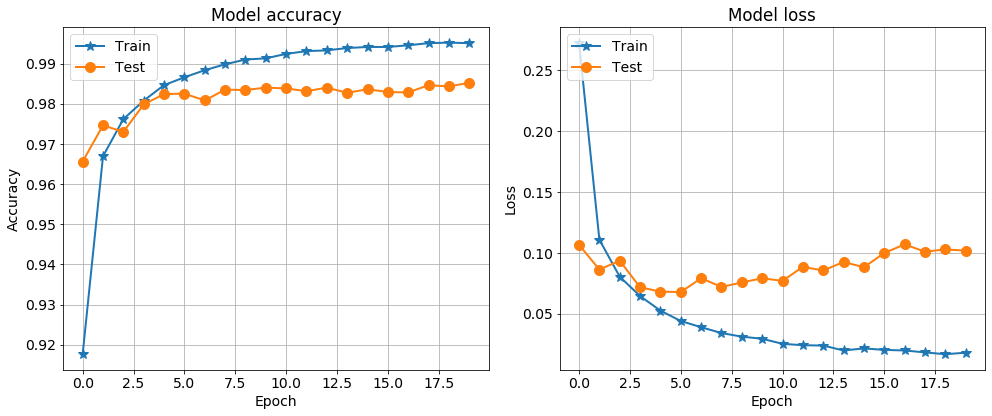

In [33]:
# Plot training & validation loss / accuracy values
plt.figure('Loss & Accuracy', figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(hmodel.history['accuracy'], '*-')
plt.plot(hmodel.history['val_accuracy'], 'o-')
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(hmodel.history['loss'], '*-')
plt.plot(hmodel.history['val_loss'], 'o-')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.grid(True)
plt.tight_layout()

In [34]:
score = model.evaluate(x_test, y_test)

print(f'Test loss     : {score[0]},\nTest accuracy : {score[1]}')

10000/10000 [==============================] - 0s 32us/step
Test loss     : 0.10184980343689917,
Test accuracy : 0.9851999878883362


### Матрица ошибок

In [35]:
y_predict = model.predict_classes(x_test)

# Confusion matrix
conf_digits = confusion_matrix(y_classes, y_predict)
print(conf_digits)

[[ 972    1    1    0    1    0    3    1    1    0]
 [   1 1127    2    1    0    0    2    0    2    0]
 [   1    2 1019    1    1    0    1    4    3    0]
 [   0    0    4  998    0    1    0    3    2    2]
 [   0    0    1    0  967    0    5    1    2    6]
 [   2    0    0    5    1  874    5    1    3    1]
 [   2    2    0    1    2    4  947    0    0    0]
 [   1    1    9    0    0    0    0 1010    3    4]
 [   2    1    3    2    2    2    1    2  954    5]
 [   3    2    0    2   12    2    0    3    1  984]]


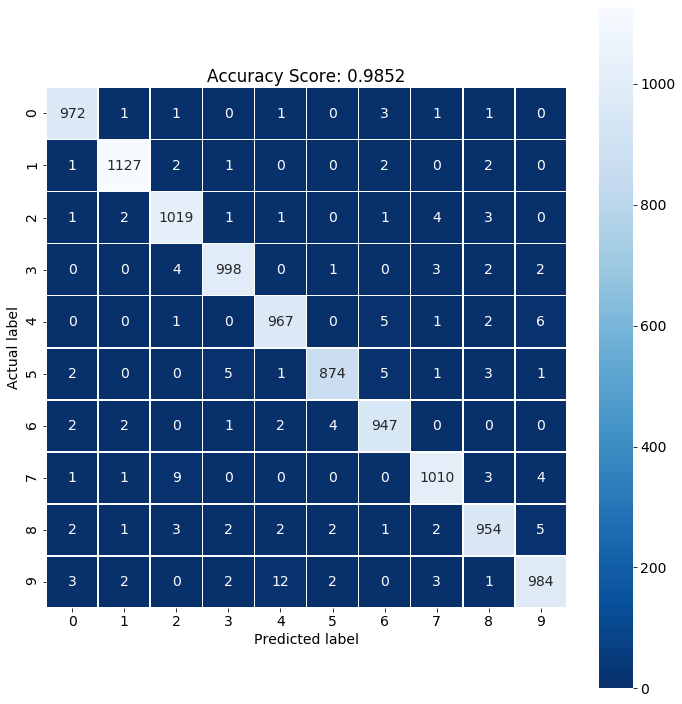

In [36]:
plt.figure('Confusion matrix', figsize=(10, 10))
sns.heatmap(conf_digits, annot=True, linewidths=.75, fmt=".0f", square=True, cmap='Blues_r');
plt.xlabel('Predicted label');
plt.ylabel('Actual label');
plt.title('Accuracy Score: {:.6}'.format(score[1]));
plt.tight_layout()

### Результат

In [37]:
print(classification_report(y_classes, y_predict))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       980
           1       0.99      0.99      0.99      1135
           2       0.98      0.99      0.98      1032
           3       0.99      0.99      0.99      1010
           4       0.98      0.98      0.98       982
           5       0.99      0.98      0.98       892
           6       0.98      0.99      0.99       958
           7       0.99      0.98      0.98      1028
           8       0.98      0.98      0.98       974
           9       0.98      0.98      0.98      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000

